# Text classification with Pytorch

The goal of this TP is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to the same dataset as before - **here, 20 newsgroup** - and then compare to models implemented in the previous TP. 

In [1]:
import torch
import torch.nn as nn

### A (very small) introduction to pytorch

Pytorch Tensors are very similar to Numpy arrays, with the added benefit of being usable on GPU. For a short tutorial on various methods to create tensors of particular types, see [this link](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).
The important things to note are that Tensors can be created empty, from lists, and it is very easy to convert a numpy array into a pytorch tensor, and inversely.

In [2]:
a = torch.LongTensor(5)
b = torch.LongTensor([5])

print(a)
print(b)

tensor([     94070833551104,                  27,      94072668684287,
        4908972153413002606, 7214836307739637349])
tensor([5])


In [3]:
a = torch.FloatTensor([2])
b = torch.FloatTensor([3])

print(a + b)

tensor([5.])


The main interest in us using Pytorch is the ```autograd``` package. ```torch.Tensor```objects have an attribute ```.requires_grad```; if set as True, it starts to track all operations on it. When you finish your computation, can call ```.backward()``` and all the gradients are computed automatically (and stored in the ```.grad``` attribute).

One way to easily cut a tensor from the computational once it is not needed anymore is to use ```.detach()```.
More info on automatic differentiation in pytorch on [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).


In [4]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2 
print(w.grad)    # w.grad = 1 
print(b.grad)    # b.grad = 1 

tensor(2.)
tensor(1.)
tensor(1.)


In [5]:
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = nn.Linear(3, 2)
for name, p in linear.named_parameters():
    print(name)
    print(p)

# Build loss function - Mean Square Error
criterion = nn.MSELoss()

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('Initial loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

weight
Parameter containing:
tensor([[ 0.3824,  0.2367, -0.2485],
        [-0.4835, -0.4065, -0.3474]], requires_grad=True)
bias
Parameter containing:
tensor([-0.1811, -0.2656], requires_grad=True)
Initial loss:  2.365093469619751
dL/dw:  tensor([[ 0.0288,  0.4257, -0.0016],
        [-0.8818, -0.8004, -0.7250]])
dL/db:  tensor([ 0.1366, -0.7181])


In [6]:
# You can perform gradient descent manually, with an in-place update ...
linear.weight.data.sub_(0.01 * linear.weight.grad.data)
linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after one update: ', loss.item())

Loss after one update:  2.3386130332946777


In [7]:
# Use the optim package to define an Optimizer that will update the weights of the model.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# By default, gradients are accumulated in buffers( i.e, not overwritten) whenever .backward()
# is called. Before the backward pass, we need to use the optimizer object to zero all of the
# gradients.
optimizer.zero_grad()
loss.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

# Print out the loss after the second step of gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after two updates: ', loss.item())

Loss after two updates:  2.312615394592285


### Tools for data processing 

```torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit ```Dataset``` and override the following methods:
- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get the i-th sample

Here is a toy example: 

In [8]:
toy_corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
              'I walk down the the avenue']

toy_categories = [0, 0, 1, 0, 0]

In [9]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # A pytorch dataset class for holding data for a text classification task.
    def __init__(self, data, categories):
        # Upon creating the Dataset object, store the data in an attribute
        # Split the text data and labels from each other
        self.X, self.Y = [], []
        for x, y in zip(data, categories):
            # We will propably need to preprocess the data - have it done in a separate method
            # We do it here because we might need corpus-wide info to do the preprocessing 
            # For example, cutting all examples to the same length
            self.X.append(self.preprocess(x))
            self.Y.append(y)
                
    # Method allowing you to preprocess data                      
    def preprocess(self, text):
        text_pp = text.lower().strip()
        return text_pp
    
    # Overriding the method __len__ so that len(CustomDatasetName) returns the number of data samples                     
    def __len__(self):
        return len(self.Y)
   
    # Overriding the method __getitem__ so that CustomDatasetName[i] returns the i-th sample of the dataset                      
    def __getitem__(self, idx):
           return self.X[idx], self.Y[idx]

In [10]:
toy_dataset = CustomDataset(toy_corpus, toy_categories)

In [11]:
print(len(toy_dataset))
for i in range(len(toy_dataset)):
    print(toy_dataset[i])

5
('i walked down down the boulevard', 0)
('i walked down the avenue', 0)
('i ran down the boulevard', 1)
('i walk down the city', 0)
('i walk down the the avenue', 0)


```torch.utils.data.DataLoader``` is what we call an iterator, which provides very useful features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.
and can be created very simply from a ```Dataset```. Continuing on our simple example: 

In [12]:
toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True)

In [13]:
for e in range(3):
    print("Epoch:" + str(e))
    for x, y in toy_dataloader:
        print("Batch: " + str(x) + "; labels: " + str(y))  

Epoch:0
Batch: ('i walk down the the avenue', 'i walked down the avenue'); labels: tensor([0, 0])
Batch: ('i walked down down the boulevard', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard',); labels: tensor([1])
Epoch:1
Batch: ('i walk down the the avenue', 'i walked down down the boulevard'); labels: tensor([0, 0])
Batch: ('i walk down the city', 'i walked down the avenue'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard',); labels: tensor([1])
Epoch:2
Batch: ('i walk down the city', 'i walk down the the avenue'); labels: tensor([0, 0])
Batch: ('i walked down down the boulevard', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walked down the avenue',); labels: tensor([0])


### Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (use what we saw in the previous TP)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

In [14]:
import os
import sys
import os.path as op
from torch.nn import functional as F
import numpy as np
import random

from torch.nn.utils.rnn import pad_sequence

First, we get the data: 

In [15]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

Example of one document:

In [16]:
print(newsgroups_train['data'][0])
print(newsgroups_train['target'][0])
print(newsgroups_train.target_names[newsgroups_train['target'][0]])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





7
rec.autos


We can now implement our ```TextClassificationDataset``` class, that we will build from:
- A list of texts in the dataset: ```data```
- A list of the corresponding categories: ```categories```
We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the testing  ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 200 by default.
- Lastly, a ```voc_threshold``` that indicates the number of words to be taken in the vocabulary. 

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0. 

In [17]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [18]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


In [19]:
import re
def clean_and_tokenize(text):    
    # Lowercase
    text = text.lower()
    # Remove anything but letters
    text = re.sub(r"[^a-z]+", " ", text)
    
    tokens = text.split()        
    return tokens

In [20]:
from collections import Counter
import itertools
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 200, voc_threshold = 5000):
        self.data = data      
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, voc_threshold)
        
        # We then need to tokenize the data .. 
        tokenized_data = [clean_and_tokenize(text) for text in data] # To complete
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data = [[self.word2idx.get(token, self.word2idx["UNK"]) for token in text] for text in tokenized_data] # To complete
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(indexes) for indexes in indexed_data] # To complete
        # And the categories into a LongTensor
        tensor_y = torch.LongTensor(categories) # To complete
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [tensor[:max_length] for tensor in tensor_data] # To complete
        
        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension 
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value = 0) # To complete
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, voc_threshold):
        """
        Same as in the previous TP: we want to output word_index, a dictionary containing words 
        and their corresponding indexes as {word : indexes} 
        But we also want the reverse, which is a dictionary {indexes: word}
        Don't forget to add a UNK token that we need when encountering unknown words
        We also choose '0' to represent the padding index, so begin the vocabulary index at 1 ! 
        """
        # To complete
        if isinstance(corpus[0],list):
            word_counts = Counter(clean_and_tokenize(" ".join(itertools.chain.from_iterable(corpus))))
        else:
            word_counts = Counter(clean_and_tokenize(" ".join(corpus)))
        # The use of a Counter object allows us to easily incorporate the threshold
        word_counts = Counter({word[0]: word[1] for word in word_counts.most_common(voc_threshold)})
        # We then add the UNK token to the counter
        word_counts.update({"UNK":1})
        # And create the word_index dictionary
        word_index = {word[0]: i+1 for i, word in enumerate(word_counts.most_common())}
        idx_word = {value:key for key, value in word_index.items()}
        return word_index, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word

In [21]:
training_dataset = TextClassificationDataset(newsgroups_train['data'], newsgroups_train['target'])
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [22]:
test_dataset = TextClassificationDataset(newsgroups_test['data'], newsgroups_test['target'], (training_word2idx, training_idx2word))

In [23]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [24]:
print(test_dataset[1])

(tensor([  16, 1998, 1995, 1998, 1686, 4188,   17,   34,   32,  770,   38,   83,
          71,   35,  145,  147,   99,   85,   97,  607,  153, 1968, 5001,   71,
        5001,    7,   25,   22, 2831,   36,   46,   24,    1,  829,    3,  117,
          32,  770, 5001,   30,  163, 1743,   98,    8,   72, 1246, 5001,    7,
         151,  223,    2,  132,   98,    6,  352,  139,   49,    3,   44,  207,
           7,  151,  223, 5001,  625,   18,   44, 2693,  511,   77, 2775, 5001,
          32, 4903,    6,    7,  151, 3078,    2, 3792, 1831, 5001,  168,   30,
         129,   10,    7,   25,  355,   12,   98,    7,   37,   15,  430,    2,
         189,   70,   32,  770,   14,    8, 5001,  204, 5001,  120,   13,   51,
          13,  171,  335,   71,   65,   32,  770, 3659,    7,   94,    7,  190,
         263,   96,    4,  243, 5001,   30,    7,   37, 1512,   11,    7,  489,
        1998, 1995, 1998, 1686, 4188,   17, 5001, 5001,  980, 4549,  123, 5001,
        5001,  335,    4, 5001,   96,  

In [25]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 200])
torch.Size([200])


### A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

In [26]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class AveragingModel(nn.Module):    
    def __init__(self, embedding_dim, vocabulary_size, nb_classes):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0) # To complete
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(embedding_dim, nb_classes) # To complete
        
        # No need for sigmoid, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = torch.mean(self.embeddings(inputs), dim=1) # To complete
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze() # To complete
        return o

In [27]:
import torch.optim as optim

In [28]:
model = AveragingModel(300, len(training_word2idx), len(newsgroups_train.target_names))
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.025, betas=(0.9, 0.999))
# The criterion is a cross entropy loss based on logits - meaning that the softmax is integrated into the criterion
criterion = nn.CrossEntropyLoss()

In [29]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model(x) # To complete
        # (2) Compute the loss 
        loss = criterion(pred,y) # To complete
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step()   
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the sigmoid
        num_corrects = torch.sum(torch.argmax(pred, dim=1) == y) # To complete
        acc = 100.0 * num_corrects/len(y)
        
        if (i%20 == 0):
            print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
    return losses

In [30]:
# Same for the evaluation ! We don't need the optimizer here. 
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            # (1) Forward
            pred = model(x) # To complete
            # (2) Compute the loss 
            loss = criterion(pred,y) # To complete
            num_corrects = torch.sum(torch.argmax(pred, dim=1) == y) # To complete
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [31]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, num_epochs = 5, early_stopping = True):
    train_losses = []
    test_losses = []
    
    if early_stopping: 
        best_valid_loss = 100000. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, test_dataloader)
        test_losses.append(valid_loss)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    # We choose to also return the test loss in order to assess overfitting in our experiments
    return train_losses, test_losses

In [32]:
model = AveragingModel(300, len(training_word2idx), len(newsgroups_train.target_names))
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.025, betas=(0.9, 0.999))
# The criterion is a cross entropy loss based on logits - meaning that the softmax is integrated into the criterion
criterion = nn.CrossEntropyLoss()
train_losses, test_losses = experiment(model, opt, criterion, early_stopping=False) # We remove early_stopping (in this case, we found it to be very strict)

Beginning training...
Epoch 1:
Batch 0 : training loss = 2.9910526275634766; training acc = 4.0
Batch 20 : training loss = 1.863439679145813; training acc = 55.0
Batch 40 : training loss = 0.9068602919578552; training acc = 79.5
Epoch 1 : Validation loss = 0.9356578168095342; Validation acc = 73.20340587287549
Epoch 2:
Batch 0 : training loss = 0.3699581027030945; training acc = 93.5
Batch 20 : training loss = 0.38799750804901123; training acc = 90.5
Batch 40 : training loss = 0.28740817308425903; training acc = 92.0
Epoch 2 : Validation loss = 0.7593362382705638; Validation acc = 78.05676442582086
Epoch 3:
Batch 0 : training loss = 0.1632966548204422; training acc = 95.5
Batch 20 : training loss = 0.24370542168617249; training acc = 94.5
Batch 40 : training loss = 0.1535671353340149; training acc = 96.0
Epoch 3 : Validation loss = 0.7516317658175696; Validation acc = 79.21665090598808
Epoch 4:
Batch 0 : training loss = 0.06405588239431381; training acc = 99.5
Batch 20 : training loss 

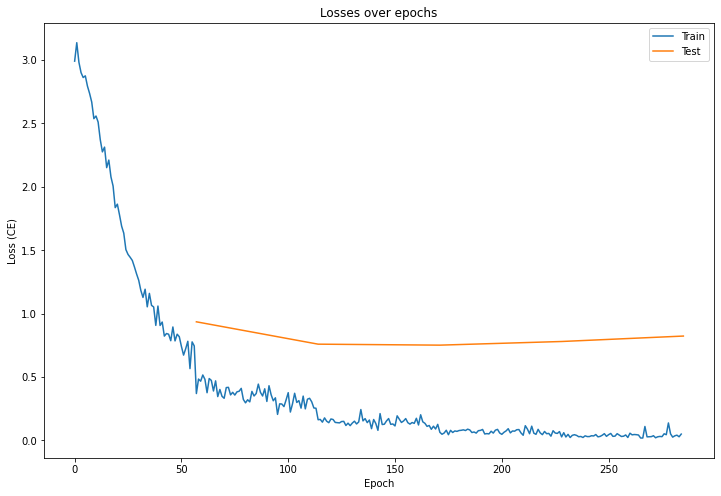

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(range(len(train_losses)), train_losses, label="Train")
plt.plot(np.array(range(1,len(test_losses)+1))*len(train_losses)/len(test_losses), test_losses, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss (CE)")
plt.title("Losses over epochs")
plt.show()

### With Glove embeddings: 

Now, we would like to integrate pre-trained word embeddings into our model ! Let's use again the functions that we used in the previous TP:

In [34]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

[==================================================] 100.0% 376.1/376.1MB downloaded


In [35]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [36]:
print(GloveEmbeddings.shape)
# We should check that the "padding" vector is at zero
print(GloveEmbeddings[0])

(5002, 300)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not ! 

In [37]:
class PretrainedAveragingModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, nb_classes, pretrained=None, finetune=False):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0) # To complete
        if pretrained != None:
            self.embeddings = self.embeddings.from_pretrained(pretrained, freeze=False)
            self.embeddings.requires_grad_(finetune)
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(embedding_dim, nb_classes) # To complete
        
        # No need for sigmoid, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs)
        x = torch.mean(x, dim=1) # To complete
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze() # To complete
        return o

### Questions: 
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ?
- Make hypothesis based on your intuition and the class on how the size of the vocabulary (change the minimum frequency of words to be taken in the vocabular) will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning).
- Verify experiments and analyze your results !

We think that using glove embeddings without fine-tuning will have the worst performance, that using no pre-trained embeddings will be second best, and that pre-training with fine-tuning will be the best. We are indeed training for a specific task : preventing fine-tuning is very likely to degrade performance, as GloVe embeddings were not trained for our task. However, if fine-tuning is allowed, embeddings trained for a more general purpose (for instance, skip-grams or CBOW) will give the model a "headstart". The embeddings will benefit from previous knowledge, that we can then fine-tune for our specific task.  
We also think that a larger vocabulary will give better results, with diminishing returns. When the vocabulary gets larger, we start training on very rare words. This can lead to overfitting rather than good generalization.

In [38]:
def experiment_train(embedding_dim, vocabulary_size, nb_classes, pretrained=None, finetune=False):
  model_pre_trained = PretrainedAveragingModel(embedding_dim, vocabulary_size, nb_classes, pretrained=pretrained, finetune=finetune)
  opt_pre_trained = optim.Adam(model_pre_trained.parameters(), lr=.05, betas=(0.9, 0.999))
  train_losses, test_losses = experiment(model_pre_trained, opt_pre_trained, criterion, early_stopping=False)
  return train_losses, test_losses

#### 5K Vocabulary

##### No pre-training

In [39]:
train_losses_5K_nopre, test_losses_5K_nopre = experiment_train(300, len(training_word2idx), len(newsgroups_train.target_names))

Beginning training...
Epoch 1:
Batch 0 : training loss = 2.9897661209106445; training acc = 6.5
Batch 20 : training loss = 1.0791385173797607; training acc = 69.0
Batch 40 : training loss = 0.6699889898300171; training acc = 80.5
Epoch 1 : Validation loss = 0.7991730900888412; Validation acc = 77.14285714105264
Epoch 2:
Batch 0 : training loss = 0.15702252089977264; training acc = 98.0
Batch 20 : training loss = 0.14331242442131042; training acc = 96.5
Batch 40 : training loss = 0.1935388743877411; training acc = 95.0
Epoch 2 : Validation loss = 0.828248940260205; Validation acc = 78.00378429337053
Epoch 3:
Batch 0 : training loss = 0.07582393288612366; training acc = 98.0
Batch 20 : training loss = 0.06230264529585838; training acc = 99.5
Batch 40 : training loss = 0.05543306842446327; training acc = 98.5
Epoch 3 : Validation loss = 0.8990441172673608; Validation acc = 78.24787133576854
Epoch 4:
Batch 0 : training loss = 0.059549666941165924; training acc = 98.5
Batch 20 : training lo

##### Pre-training without fine-tuning

In [40]:
train_losses_5K_False, test_losses_5K_False = experiment_train(300, len(training_word2idx), len(newsgroups_train.target_names), torch.FloatTensor(GloveEmbeddings), False)

Beginning training...
Epoch 1:
Batch 0 : training loss = 3.0009067058563232; training acc = 7.5
Batch 20 : training loss = 2.087541341781616; training acc = 42.5
Batch 40 : training loss = 1.6427125930786133; training acc = 58.5
Epoch 1 : Validation loss = 1.645466546349178; Validation acc = 56.10217597153013
Epoch 2:
Batch 0 : training loss = 1.5618391036987305; training acc = 57.5
Batch 20 : training loss = 1.4555507898330688; training acc = 61.5
Batch 40 : training loss = 1.2996562719345093; training acc = 62.0
Epoch 2 : Validation loss = 1.4115676129890593; Validation acc = 60.38599810695017
Epoch 3:
Batch 0 : training loss = 1.1948812007904053; training acc = 76.5
Batch 20 : training loss = 1.2336890697479248; training acc = 60.5
Batch 40 : training loss = 1.1636568307876587; training acc = 69.0
Epoch 3 : Validation loss = 1.2991320980305703; Validation acc = 63.307473984775164
Epoch 4:
Batch 0 : training loss = 1.1734585762023926; training acc = 68.5
Batch 20 : training loss = 0.

##### Pre-training with fine-tuning

In [41]:
train_losses_5K_True, test_losses_5K_True = experiment_train(300, len(training_word2idx), len(newsgroups_train.target_names), torch.FloatTensor(GloveEmbeddings), True)

Beginning training...
Epoch 1:
Batch 0 : training loss = 2.9958536624908447; training acc = 1.5
Batch 20 : training loss = 0.9067810773849487; training acc = 77.0
Batch 40 : training loss = 0.5174518823623657; training acc = 85.0
Epoch 1 : Validation loss = 0.7674109812406514; Validation acc = 77.88457899535729
Epoch 2:
Batch 0 : training loss = 0.22440169751644135; training acc = 94.0
Batch 20 : training loss = 0.23318853974342346; training acc = 92.0
Batch 40 : training loss = 0.2676600217819214; training acc = 95.0
Epoch 2 : Validation loss = 0.8111259005963802; Validation acc = 78.14380322386887
Epoch 3:
Batch 0 : training loss = 0.058882612735033035; training acc = 99.0
Batch 20 : training loss = 0.05627557262778282; training acc = 98.5
Batch 40 : training loss = 0.039704330265522; training acc = 99.5
Epoch 3 : Validation loss = 0.8920696734000515; Validation acc = 78.2743614019937
Epoch 4:
Batch 0 : training loss = 0.010098803788423538; training acc = 100.0
Batch 20 : training lo

#### 20k vocabulary

In [42]:
training_dataset_20 = TextClassificationDataset(newsgroups_train['data'], newsgroups_train['target'], voc_threshold = 20000)
training_word2idx_20, training_idx2word_20 = training_dataset.get_vocab()

In [43]:
test_dataset_20 = TextClassificationDataset(newsgroups_test['data'], newsgroups_test['target'], (training_word2idx, training_idx2word))

In [44]:
training_dataloader_20 = DataLoader(training_dataset, batch_size = 200, shuffle=True)
test_dataloader_20 = DataLoader(test_dataset, batch_size = 25)

In [45]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings_20 = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx_20)

##### No pre-training

In [46]:
train_losses_20K_nopre, test_losses_20K_nopre = experiment_train(300, len(training_word2idx_20), len(newsgroups_train.target_names))

Beginning training...
Epoch 1:
Batch 0 : training loss = 2.996387004852295; training acc = 9.0
Batch 20 : training loss = 1.0842682123184204; training acc = 74.0
Batch 40 : training loss = 0.5286743640899658; training acc = 87.0
Epoch 1 : Validation loss = 0.832328356259706; Validation acc = 76.22327342254437
Epoch 2:
Batch 0 : training loss = 0.2248370349407196; training acc = 93.0
Batch 20 : training loss = 0.21596817672252655; training acc = 95.5
Batch 40 : training loss = 0.19656208157539368; training acc = 94.0
Epoch 2 : Validation loss = 0.83791134506464; Validation acc = 77.51371806820497
Epoch 3:
Batch 0 : training loss = 0.055707626044750214; training acc = 99.0
Batch 20 : training loss = 0.07265695929527283; training acc = 99.0
Batch 40 : training loss = 0.030415290966629982; training acc = 100.0
Epoch 3 : Validation loss = 0.882529852726799; Validation acc = 77.97161779340529
Epoch 4:
Batch 0 : training loss = 0.036477528512477875; training acc = 99.5
Batch 20 : training los

##### Pre-training without fine-tuning

In [47]:
train_losses_20K_False, test_losses_20K_False = experiment_train(300, len(training_word2idx_20), len(newsgroups_train.target_names), torch.FloatTensor(GloveEmbeddings_20), False)

Beginning training...
Epoch 1:
Batch 0 : training loss = 2.9918956756591797; training acc = 3.5
Batch 20 : training loss = 2.180598258972168; training acc = 40.5
Batch 40 : training loss = 1.7630691528320312; training acc = 53.0
Epoch 1 : Validation loss = 1.6472102218116356; Validation acc = 57.082308421861256
Epoch 2:
Batch 0 : training loss = 1.5475589036941528; training acc = 62.0
Batch 20 : training loss = 1.4387699365615845; training acc = 59.5
Batch 40 : training loss = 1.3125454187393188; training acc = 60.5
Epoch 2 : Validation loss = 1.4212381377914884; Validation acc = 60.69820246159636
Epoch 3:
Batch 0 : training loss = 1.2516530752182007; training acc = 65.5
Batch 20 : training loss = 1.1601473093032837; training acc = 70.5
Batch 40 : training loss = 1.0172982215881348; training acc = 75.5
Epoch 3 : Validation loss = 1.3012921180551416; Validation acc = 63.71807001126523
Epoch 4:
Batch 0 : training loss = 1.0174150466918945; training acc = 72.5
Batch 20 : training loss = 1

##### Pre-training with fine-tuning

In [48]:
train_losses_20K_True, test_losses_20K_True = experiment_train(300, len(training_word2idx_20), len(newsgroups_train.target_names), torch.FloatTensor(GloveEmbeddings_20), True)

Beginning training...
Epoch 1:
Batch 0 : training loss = 2.996785879135132; training acc = 5.0
Batch 20 : training loss = 0.9974758625030518; training acc = 72.0
Batch 40 : training loss = 0.6107787489891052; training acc = 80.5
Epoch 1 : Validation loss = 0.8330860273628835; Validation acc = 76.54115421724636
Epoch 2:
Batch 0 : training loss = 0.14512337744235992; training acc = 96.5
Batch 20 : training loss = 0.3252655863761902; training acc = 90.5
Batch 40 : training loss = 0.2082514762878418; training acc = 94.5
Epoch 2 : Validation loss = 0.8562474658355018; Validation acc = 77.45506150201456
Epoch 3:
Batch 0 : training loss = 0.13186751306056976; training acc = 96.5
Batch 20 : training loss = 0.06359067559242249; training acc = 99.0
Batch 40 : training loss = 0.053653568029403687; training acc = 98.5
Epoch 3 : Validation loss = 0.9096681879746993; Validation acc = 78.42005676623212
Epoch 4:
Batch 0 : training loss = 0.0761394277215004; training acc = 99.0
Batch 20 : training loss

#### Evaluation

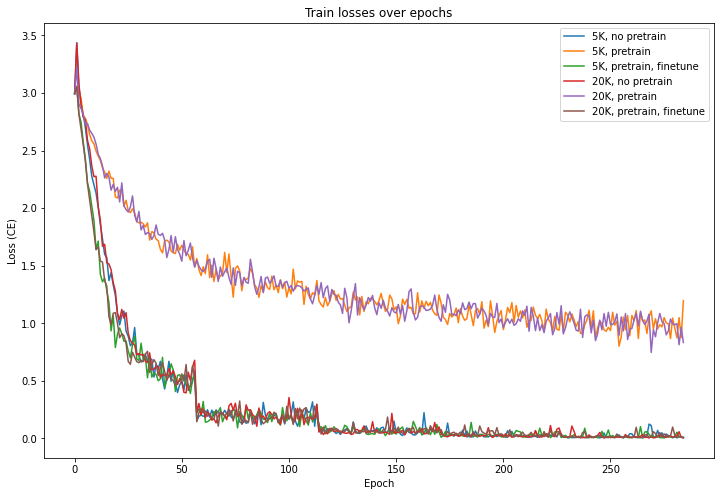

In [49]:
plt.figure(figsize=(12,8))
plt.plot(train_losses_5K_nopre, label="5K, no pretrain")
plt.plot(train_losses_5K_False, label="5K, pretrain")
plt.plot(train_losses_5K_True, label="5K, pretrain, finetune")
plt.plot(train_losses_20K_nopre, label="20K, no pretrain")
plt.plot(train_losses_20K_False, label="20K, pretrain")
plt.plot(train_losses_20K_True, label="20K, pretrain, finetune")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss (CE)")
plt.title("Train losses over epochs")
plt.show()

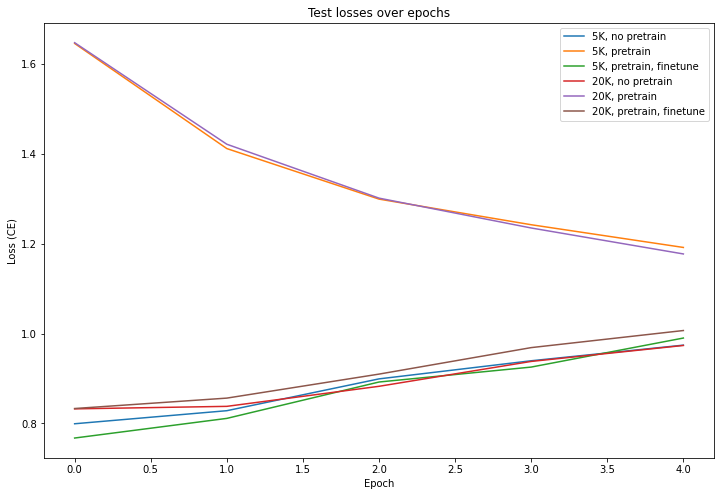

In [50]:
plt.figure(figsize=(12,8))
plt.plot(test_losses_5K_nopre, label="5K, no pretrain")
plt.plot(test_losses_5K_False, label="5K, pretrain")
plt.plot(test_losses_5K_True, label="5K, pretrain, finetune")
plt.plot(test_losses_20K_nopre, label="20K, no pretrain")
plt.plot(test_losses_20K_False, label="20K, pretrain")
plt.plot(test_losses_20K_True, label="20K, pretrain, finetune")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss (CE)")
plt.title("Test losses over epochs")
plt.show()

The results are in line with our previous statements.

### LSTM Cells in pytorch

In [51]:
# Create a toy example of LSTM: 
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# LSTMs expect inputs having 3 dimensions:
# - The first dimension is the temporal dimension, along which we (in our case) have the different words
# - The second dimension is the batch dimension, along which we stack the independant batches
# - The third dimension is the feature dimension, along which are the features of the vector representing the words

# In our toy case, we have inputs and outputs containing 3 features (third dimension !)
# We created a sequence of 5 different inputs (first dimension !)
# We don't use batch (the second dimension will have one lement)

# We need an initial hidden state, of the right sizes for dimension 2/3, but with only one temporal element:
# Here, it is:
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
# Why do we create a tuple of two tensors ? Because we use LSTMs: remember that they use two sets of weights,
# and two hidden states (Hidden state, and Cell state).
# If you don't remember, read: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# If we used a classic RNN, we would simply have:
# hidden = torch.randn(1, 1, 3)

# The naive way of applying a lstm to inputs is to apply it one step at a time, and loop through the sequence
for i in inputs:
    # After each step, hidden contains the hidden states (remember, it's a tuple of two states).
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    
# Alternatively, we can do the entire sequence all at once.
# The first value returned by LSTM is all of the Hidden states throughout the sequence.
# The second is just the most recent Hidden state and Cell state (you can compare the values)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence, for each temporal step
# "hidden" will allow you to continue the sequence and backpropagate later, with another sequence
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # Re-initialize
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[ 2.0223e-02, -8.7944e-02, -3.1408e-01]],

        [[-3.4109e-02, -9.8597e-02, -4.2165e-01]],

        [[-1.8471e-02, -1.0387e-01, -1.9008e-01]],

        [[-3.3814e-02, -9.2571e-02, -1.6050e-01]],

        [[-2.4771e-02, -2.1275e-04, -3.0755e-01]]], grad_fn=<StackBackward0>)
(tensor([[[-2.4771e-02, -2.1275e-04, -3.0755e-01]]], grad_fn=<StackBackward0>), tensor([[[-0.0767, -0.0012, -0.3710]]], grad_fn=<StackBackward0>))


### Creating our own LSTM Model

We'll implement now a LSTM model, taking the same inputs and also outputing a score for the sentence.

In [52]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, nb_classes,  pretrained=None, finetune=False):
        # To complete 
        # You will need to create the LSTM layer before the linear layer : use nn.LSTM and be careful with the dimensions !  
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0) # To complete
        if pretrained != None:
            self.embeddings = self.embeddings.from_pretrained(pretrained, freeze=False)
            self.embeddings.requires_grad_(finetune)
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, nb_classes) # To complete  

    def forward(self, inputs):
        # To complete 
        # Process the input and apply the LSTM
        # The output will have three dimensions (batch, temporal, nb_classes) - there is one that we won't entirely keep, since this is a many-to-one network
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x, _ = self.lstm(self.embeddings(inputs)) # To complete
        x = x[:,-1,:]
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze() # To complete
        return o


### Questions: 
- What do you see with a simple application of LSTM models ? (Again, try with the three possible settings !) What are possible reasons for this ? (these could be linked to the data, the way it is pre-processed, the architecture, and the training procedure). 

In [53]:
def experiment_lstm(embedding_dim, vocabulary_size, hidden_dim, nb_classes, pretrained=None, finetune=False):
  model_pre_trained = LSTMModel(embedding_dim, vocabulary_size, hidden_dim, nb_classes, pretrained=pretrained, finetune=finetune)
  opt_pre_trained = optim.Adam(model_pre_trained.parameters(), lr=.05, betas=(0.9, 0.999))
  train_losses, test_losses = experiment(model_pre_trained, opt_pre_trained, criterion, early_stopping=False)
  return train_losses, test_losses

In [54]:
LSTM_5K_nopre, LSTM_test_5K_nopre = experiment_lstm(300, len(training_word2idx), 100, len(newsgroups_train.target_names))

Beginning training...
Epoch 1:
Batch 0 : training loss = 2.9963266849517822; training acc = 4.0
Batch 20 : training loss = 2.976375102996826; training acc = 6.0
Batch 40 : training loss = 2.99884033203125; training acc = 6.0
Epoch 1 : Validation loss = 3.043836048896739; Validation acc = 7.046357615894039
Epoch 2:
Batch 0 : training loss = 2.815897226333618; training acc = 15.0
Batch 20 : training loss = 2.880830764770508; training acc = 14.0
Batch 40 : training loss = 2.8422303199768066; training acc = 9.5
Epoch 2 : Validation loss = 3.1417460631061074; Validation acc = 7.000946073342633
Epoch 3:
Batch 0 : training loss = 2.5715558528900146; training acc = 22.5
Batch 20 : training loss = 2.879890203475952; training acc = 13.5
Batch 40 : training loss = 2.9304261207580566; training acc = 11.5
Epoch 3 : Validation loss = 3.1869962539104435; Validation acc = 8.026490066225165
Epoch 4:
Batch 0 : training loss = 2.4548850059509277; training acc = 25.0
Batch 20 : training loss = 2.876102209

In [55]:
LSTM_5K_False, LSTM_test_5K_False = experiment_lstm(300, len(training_word2idx), 100, len(newsgroups_train.target_names), torch.FloatTensor(GloveEmbeddings), False)

Beginning training...
Epoch 1:
Batch 0 : training loss = 3.0076632499694824; training acc = 5.0
Batch 20 : training loss = 2.776240348815918; training acc = 10.5
Batch 40 : training loss = 2.729414701461792; training acc = 16.0
Epoch 1 : Validation loss = 2.515830034451769; Validation acc = 16.298959318375747
Epoch 2:
Batch 0 : training loss = 2.3837342262268066; training acc = 20.5
Batch 20 : training loss = 2.0647385120391846; training acc = 28.0
Batch 40 : training loss = 1.89408540725708; training acc = 38.0
Epoch 2 : Validation loss = 1.8492614883460745; Validation acc = 35.366130557281295
Epoch 3:
Batch 0 : training loss = 1.6008247137069702; training acc = 44.5
Batch 20 : training loss = 1.6869609355926514; training acc = 40.0
Batch 40 : training loss = 1.5321992635726929; training acc = 50.0
Epoch 3 : Validation loss = 1.6432480703521248; Validation acc = 46.798486280125495
Epoch 4:
Batch 0 : training loss = 1.313511610031128; training acc = 56.0
Batch 20 : training loss = 1.36

In [56]:
LSTM_5K_True, LSTM_test_5K_True = experiment_lstm(300, len(training_word2idx), 100, len(newsgroups_train.target_names), torch.FloatTensor(GloveEmbeddings), True)

Beginning training...
Epoch 1:
Batch 0 : training loss = 2.9967031478881836; training acc = 4.5
Batch 20 : training loss = 2.9050703048706055; training acc = 13.5
Batch 40 : training loss = 2.728327989578247; training acc = 16.5
Epoch 1 : Validation loss = 2.798100661757766; Validation acc = 12.404919583276408
Epoch 2:
Batch 0 : training loss = 2.5547449588775635; training acc = 20.0
Batch 20 : training loss = 2.504699945449829; training acc = 25.5
Batch 40 : training loss = 2.505413770675659; training acc = 17.0
Epoch 2 : Validation loss = 2.6542606993226814; Validation acc = 16.31220435148833
Epoch 3:
Batch 0 : training loss = 2.414893388748169; training acc = 20.0
Batch 20 : training loss = 2.431255578994751; training acc = 24.0
Batch 40 : training loss = 2.4422595500946045; training acc = 19.5
Epoch 3 : Validation loss = 2.6170103190750478; Validation acc = 18.327341534444038
Epoch 4:
Batch 0 : training loss = 2.1397268772125244; training acc = 29.5
Batch 20 : training loss = 2.400

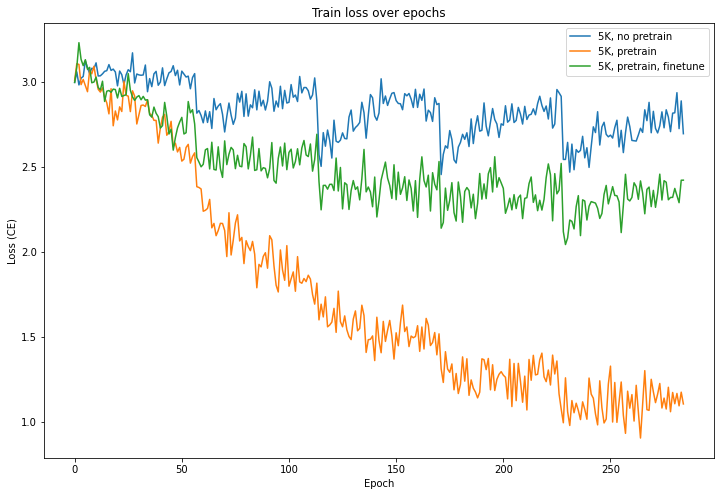

In [57]:
plt.figure(figsize=(12,8))
plt.plot(LSTM_5K_nopre, label="5K, no pretrain")
plt.plot(LSTM_5K_False, label="5K, pretrain")
plt.plot(LSTM_5K_True, label="5K, pretrain, finetune")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss (CE)")
plt.title("Train loss over epochs")
plt.show()

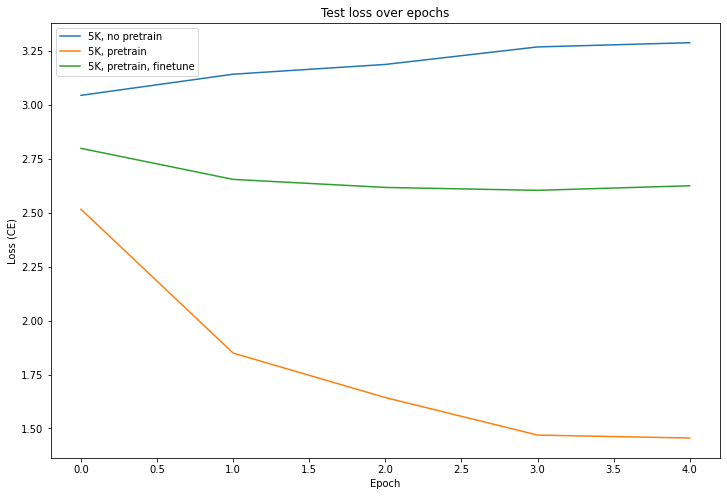

In [58]:
plt.figure(figsize=(12,8))
plt.plot(LSTM_test_5K_nopre, label="5K, no pretrain")
plt.plot(LSTM_test_5K_False, label="5K, pretrain")
plt.plot(LSTM_test_5K_True, label="5K, pretrain, finetune")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss (CE)")
plt.title("Test loss over epochs")
plt.show()

Our LSTM model does not give better results than our simple averaging model.
In this instance, the sequentiality of the data might not capture more information than an average of the embeddings of the words. We are trying to compute the topic of a document. This information can most likely be captured through the overall meaning of words contained in the document. Possible applications where the sequentiality of the data can have an importance could be translation, POS tagging, etc.
We are also witnessing massive overfitting, and in this case, no finetuning seems to lead to less overfitting. This is not surprising, as avoiding the backpropagation to the embedding layer, we make sure that specific layer will never overfit. The reason of the overfitting might be that the hidden dimension is too big, and our model is too complex given the training task (we have a lot of parameters, and this can be felt even during training : it takes a lot more time to train the LSTM models than our averaging models).

# Fine-tuning a Bert model

Fine-tune the lightest BERT model available on the data and compare it with previous results ! The code given here comes from the following tutorial, slightly adapted to our data:
https://huggingface.co/transformers/custom_datasets.html#seq-imdb

We re-trained this model but an unfortunate "Run all" ruined it. It obviously gave way better results than all previous models.

In [59]:
!pip install transformers
import transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 44.3 MB/s 
     |████████████████████████████████| 6.5 MB 56.5 MB/s 
     |████████████████████████████████| 596 kB 60.5 MB/s 
     |████████████████████████████████| 77 kB 8.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [60]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [61]:
train_encodings = tokenizer(newsgroups_train['data'], truncation=True, padding=True)
test_encodings = tokenizer(newsgroups_test['data'], truncation=True, padding=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-2115e60750e7>", line 1, in <module>
    train_encodings = tokenizer(newsgroups_train['data'], truncation=True, padding=True)
  File "/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py", line 2472, in __call__
    **kwargs,
  File "/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py", line 2663, in batch_encode_plus
    **kwargs,
  File "/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_fast.py", line 428, in _batch_encode_plus
    is_pretokenized=is_split_into_words,
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback

KeyboardInterrupt: ignored

In [ ]:
class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ClassificationDataset(train_encodings, newsgroups_train['target'])
test_dataset = ClassificationDataset(test_encodings, newsgroups_test['target'])

In [ ]:
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score  

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=1,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=250,
)

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = len(newsgroups_train.target_names))

In [ ]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,           
    compute_metrics=compute_metrics             
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()